In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In real life, we mostly identify the people from their faces and this what I am going to do here.
Sometimes the face is not clear or maybe be sideways. So to keep things simple, I will also try to detect two eyes and only then I will keep that image.

I will use haar cascade from opencv for this. Here is an article on this: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html?highlight=haar

### 1. Detect face and eyes

In [2]:
img = cv2.imread('./test_images/Tom_Hiddleston_full.jpg')
img.shape

(330, 220, 3)

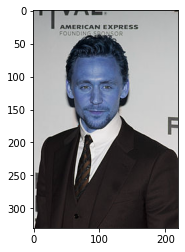

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(330, 220)

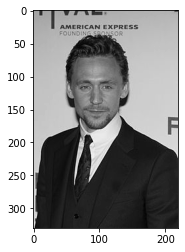

In [5]:
plt.imshow(gray, cmap='gray')

In [6]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[51, 80, 92, 92]], dtype=int32)

'faces' is an array which contains faces in the image. As of now it return only one face(x, y, width, height)

In [7]:
(x,y,w,h) = faces[0]
x,y,w,h

(51, 80, 92, 92)

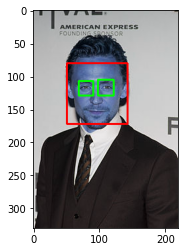

In [8]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
  
plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

### 2. Crop the facial region of the image

**If eyes >=2, then save and crop the face region and if face is not very clear and it doesn't have two eyes clearly visible**

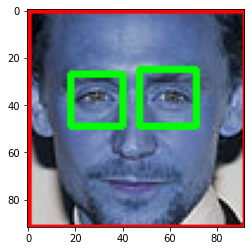

In [10]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [11]:
cropped_img = np.array(roi_color)
cropped_img.shape

(92, 92, 3)

**a. Face clear and eyes>=2**

In [14]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

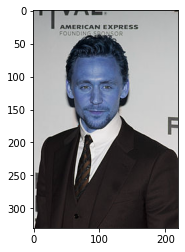

In [16]:
full_img = cv2.imread('./test_images/Tom_Hiddleston_full.jpg')
plt.imshow(full_img)

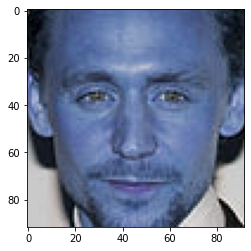

In [17]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/Tom_Hiddleston_full.jpg')
plt.imshow(cropped_image)

**b. Face is not clear or eyes<2**

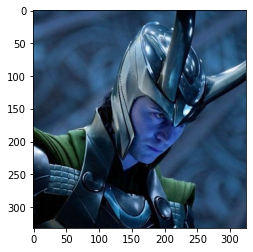

In [20]:
partial_face_image = cv2.imread('./test_images/Tom_Hiddleston_partial.jpg')
plt.imshow(partial_face_image)

In [21]:
cropped_image_partial_face = get_cropped_image_if_2_eyes('./test_images/Tom_Hiddleston_partial.jpg')
cropped_image_partial_face

**cropped_image_partial_face is 'None' which means this image will not be used.**

### 3. Wavelet Transform

**In wavelet transformed image, we can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc**


In [29]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

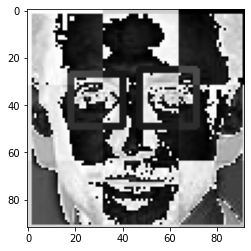

In [30]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

**Both raw image and this transformed image will be used as inputs to the model.**

### 4. Data Preprocessing

In [47]:
path_img = "./dataset/"
path_crp_img = "./dataset/cropped/"

In [60]:
import os
import shutil
img_dirs = []
#delete the directory if already exists and make a new one
if os.path.exists(path_crp_img):
    shutil.rmtree(path_crp_img)
for entry in os.scandir(path_img):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [61]:
img_dirs

['./dataset/jeremy_renner',
 './dataset/scarlett johansson',
 './dataset/chris_hemsworth',
 './dataset/chris_evans',
 './dataset/robert_downey_jr']

**Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code**

In [62]:
os.mkdir(path_crp_img)

In [63]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_crp_img + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./dataset/cropped/jeremy_renner
Generating cropped images in folder:  ./dataset/cropped/scarlett johansson
Generating cropped images in folder:  ./dataset/cropped/chris_hemsworth
Generating cropped images in folder:  ./dataset/cropped/chris_evans
Generating cropped images in folder:  ./dataset/cropped/robert_downey_jr


**Cropped images are stored in the cropped folder.
Now i am going to remove some unwanted images from the cropped folder (data cleaning).**

In [65]:
#rebuilding the cropped image dictionary as I deleted few unwanted images.
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'jeremy_renner': ['./dataset/cropped/jeremy_renner/jeremy_renner34.png',
  './dataset/cropped/jeremy_renner/jeremy_renner15.png',
  './dataset/cropped/jeremy_renner/jeremy_renner33.png',
  './dataset/cropped/jeremy_renner/jeremy_renner18.png',
  './dataset/cropped/jeremy_renner/jeremy_renner39.png',
  './dataset/cropped/jeremy_renner/jeremy_renner5.png',
  './dataset/cropped/jeremy_renner/jeremy_renner2.png',
  './dataset/cropped/jeremy_renner/jeremy_renner28.png',
  './dataset/cropped/jeremy_renner/jeremy_renner13.png',
  './dataset/cropped/jeremy_renner/jeremy_renner21.png',
  './dataset/cropped/jeremy_renner/jeremy_renner31.png',
  './dataset/cropped/jeremy_renner/jeremy_renner10.png',
  './dataset/cropped/jeremy_renner/jeremy_renner35.png',
  './dataset/cropped/jeremy_renner/jeremy_renner6.png',
  './dataset/cropped/jeremy_renner/jeremy_renner27.png',
  './dataset/cropped/jeremy_renner/jeremy_renner38.png',
  './dataset/cropped/jeremy_renner/jeremy_renner1.png',
  './dataset/cropp

In [66]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'jeremy_renner': 0,
 'scarlett johansson': 1,
 'chris_hemsworth': 2,
 'chris_evans': 3,
 'robert_downey_jr': 4}

### 5. Creating training and test set
**Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now**

In [67]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scaled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scaled_img_har = cv2.resize(img_har, (32, 32))
        #stacking both images vertically
        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [68]:
len(X[0])

4096

In [71]:
len(X)

156

In [69]:
32*32*3 + 32*32 #32*32 raw image + 32*32 wavlet transformed image

4096

In [70]:
X[0]

array([[ 39],
       [ 48],
       [ 67],
       ...,
       [ 53],
       [164],
       [158]], dtype=uint8)

In [72]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(156, 4096)

In [73]:
from sklearn.model_selection import train_test_split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### 6. Model Training

** Using SVM with rbf kernel tuned with heuristic fine tuning.**

In [76]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [85]:
# Scaling the data and then creating the model
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', C=5))])

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.6153846153846154

In [86]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.50      0.71      0.59         7
           1       0.62      0.50      0.56        10
           2       1.00      0.60      0.75         5
           3       1.00      0.56      0.71         9
           4       0.46      0.75      0.57         8

    accuracy                           0.62        39
   macro avg       0.72      0.62      0.64        39
weighted avg       0.70      0.62      0.63        39



**Using GridSearchCV to try out different models with different paramets.**

In [88]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [89]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [90]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.659420,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.479710,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.651087,{'logisticregression__C': 1}


In [91]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [92]:
best_estimators['svm'].score(X_test,y_test)

0.5897435897435898

In [93]:
best_estimators['random_forest'].score(X_test,y_test)

0.3333333333333333

In [94]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.5897435897435898

In [99]:
best_clf = best_estimators['logistic_regression']

### 7. Confusion Matrix

In [103]:
from sklearn.metrics import confusion_matrix
cm_lr = confusion_matrix(y_test, best_estimators['logistic_regression'].predict(X_test))
cm_svm = confusion_matrix(y_test, best_estimators['svm'].predict(X_test))

Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

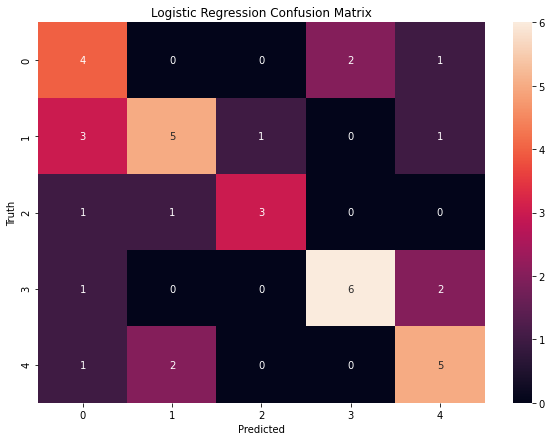

In [104]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm_lr, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Logistic Regression Confusion Matrix')

Text(0.5, 1.0, 'SVM Confusion Matrix')

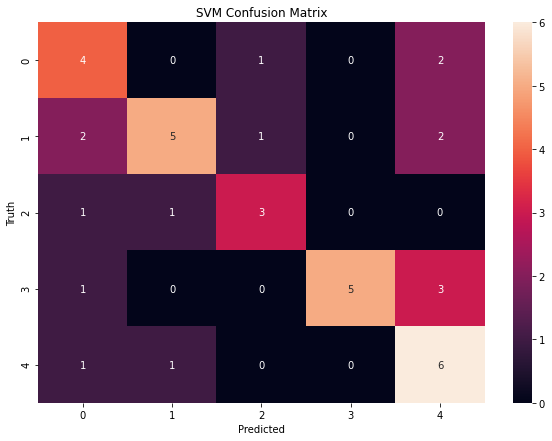

In [105]:
plt.figure(figsize = (10,7))
sn.heatmap(cm_svm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('SVM Confusion Matrix')

In [106]:
class_dict

{'jeremy_renner': 0,
 'scarlett johansson': 1,
 'chris_hemsworth': 2,
 'chris_evans': 3,
 'robert_downey_jr': 4}

**Both are performing equally good and bad considering the data I have used is very limited and also not of very high quality.**

### 8. Save the trained model and class dictionary 

In [107]:
import joblib 
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

In [ ]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))